1. 經典無監督 (PCA + K-means / GMM) 做 microstructure clustering + 異常分數

2. CNN Autoencoder 做 patch-level anomaly detection（主角）

3. Self-supervised 表徵學習 + One-Class SVM / Isolation Forest

$$整個計畫的目標$$
輸入: 一張 SEM 影像

輸出:

*   一張 anomaly heatmap 顯示哪裡可能是孔洞、夾雜、異常晶粒、加工缺陷…


*   或標示這張圖是「正常 microstructure」還是「有可疑缺陷」。



$$在 Colab 自動建立 kaggle.json$$



In [3]:
import json, os

kaggle_info = {
    "username": "e54111213",
    "key": "1d40979da9e5764403b80be6954b09f1"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_info, f)

!chmod 600 /root/.kaggle/kaggle.json


$$安裝 Kaggle CLI$$

In [4]:
!pip install kaggle


https://www.kaggle.com/datasets/dragonzhang/grainsize-train?resource=download

$$下載指定 dataset$$

In [5]:
!kaggle datasets download -d dragonzhang/grainsize-train



Dataset URL: https://www.kaggle.com/datasets/dragonzhang/grainsize-train
License(s): unknown
100% 1.66G/1.66G [00:23<00:00, 105MB/s]
100% 1.66G/1.66G [00:23<00:00, 76.4MB/s]


$$解壓縮 Dataset$$

In [6]:
!unzip -q grainsize-train.zip -d grainsize_dataset


In [7]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

DATA_ROOT = Path("/content/grainsize_dataset")  # 解壓縮後的資料夾
IMG_EXT = [".jpg", ".png", ".jpeg", ".tif", ".tiff"]

# 收集所有影像路徑（含子資料夾）
image_paths = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in IMG_EXT]
print("共有影像張數：", len(image_paths))
image_paths[:5]


共有影像張數： 4222


[PosixPath('/content/grainsize_dataset/train/10.0/152-100-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/126-102-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/146-101-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/194-101-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/182-101-10.0-500x.jpg')]

簡單看一張圖確認：

(np.float64(-0.5), np.float64(1375.5), np.float64(1103.5), np.float64(-0.5))

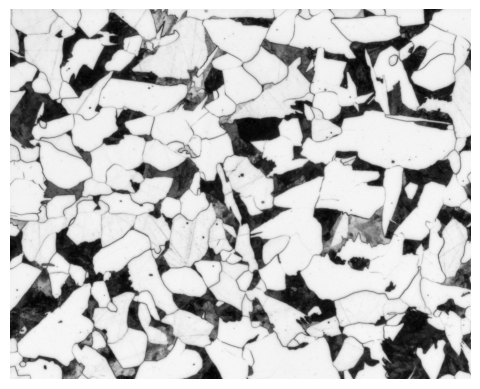

In [8]:
img0 = cv2.imread(str(image_paths[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img0, cmap='gray')
plt.axis('off')


$1. 前處理：灰階 + Normalize +（選配）縮放$

這邊先做最基本版：

轉灰階（如果原本已經是灰階，讀進來就會是單通道）

Normalize 到 0–1 之間

如果你之後希望統一尺寸，也可以在這裡 cv2.resize。

shape: (1104, 1376) min: 0.043137256 max: 0.80784315


(np.float64(-0.5), np.float64(1375.5), np.float64(1103.5), np.float64(-0.5))

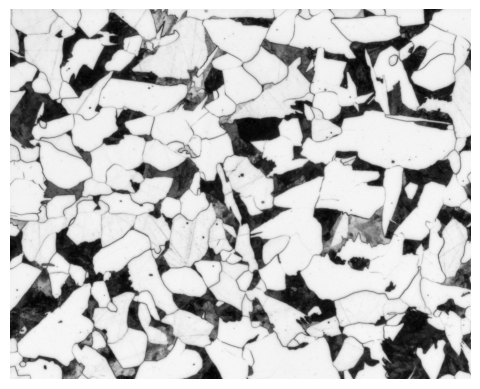

In [9]:
def preprocess_image(path, resize_to=(512, 512)):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")

    if resize_to is not None:
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)

    # 轉成 float32 然後做 normalize
    img = img.astype(np.float32) / 255.0

    return img

# 測試
img = preprocess_image(image_paths[0], resize_to=None)
print("shape:", img.shape, "min:", img.min(), "max:", img.max())
plt.imshow(img, cmap='gray')
plt.axis('off')


2. 切 Patch 的函式（這是之後 unsupervised 的基本單位）

圖被切成幾個 patch : 1386
每個 patch 尺寸: (64, 64)


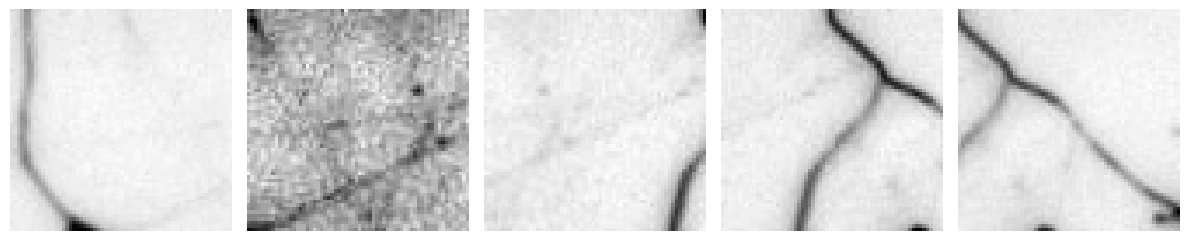

In [11]:
def extract_patches(img, patch_size=64, stride=32):

    H, W = img.shape
    patches = []
    coords = []

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            coords.append((y, x))

    patches = np.stack(patches, axis=0)
    coords = np.array(coords)
    return patches, coords

# 測試
patches, coords = extract_patches(img, patch_size=64, stride=32)
print("圖被切成幾個 patch :", patches.shape[0])
print("每個 patch 尺寸:", patches.shape[1:])

# 看幾個 patch 檢查
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(patches[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


3. 對整個 Dataset 切 patch + 建立 Meta 資訊

接著，我們把所有影像跑一遍：

all_patches：堆在一起的所有 patch → 之後拿去做 PCA / Autoencoder

meta：記錄每個 patch 來自哪一張圖、以及在原圖的 (y, x) 座標，之後畫 heatmap 用得上

In [12]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt


In [13]:
DATA_ROOT = Path("/content/grainsize_dataset")   # 你的 dataset 資料夾路徑
IMG_EXT = [".jpg", ".png", ".jpeg", ".tif", ".tiff"]

image_paths = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in IMG_EXT]

print("找到影像數量:", len(image_paths))
image_paths[:5]


找到影像數量: 4222


[PosixPath('/content/grainsize_dataset/train/10.0/152-100-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/126-102-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/146-101-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/194-101-10.0-500x.jpg'),
 PosixPath('/content/grainsize_dataset/train/10.0/182-101-10.0-500x.jpg')]

In [14]:
def preprocess_image(path, resize_to=None):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = img.astype(np.float32) / 255.0
    if resize_to is not None:
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
    return img


def extract_patches(img, patch_size=64, stride=32):
    H, W = img.shape
    patches = []
    coords = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            coords.append((y, x))
    return np.stack(patches), np.array(coords)


In [15]:
import cv2
import numpy as np
from pathlib import Path

DATA_ROOT = Path("/content/grainsize_dataset")
IMG_EXT = [".jpg", ".png", ".jpeg", ".tif", ".tiff"]

image_paths = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in IMG_EXT]
print("找到影像數量:", len(image_paths))

def preprocess_image(path, resize_to=(512, 512)):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    return img

def extract_patches(img, patch_size=64, stride=32):
    H, W = img.shape
    patches = []
    coords = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            coords.append((y, x))
    return np.stack(patches), np.array(coords)


找到影像數量: 4222


In [17]:
PATCH_SIZE = 64
STRIDE = 32
MAX_PATCHES_TOTAL = 80000

all_patches = []
meta_info = []

total_patches = 0

for img_id, path in enumerate(image_paths):
    img = preprocess_image(path, resize_to=(512, 512))
    patches, coords = extract_patches(img, patch_size=PATCH_SIZE, stride=STRIDE)

    # 如果超過限制，就只取前面幾個
    if total_patches + patches.shape[0] > MAX_PATCHES_TOTAL:
        remain = MAX_PATCHES_TOTAL - total_patches
        if remain <= 0:
            break
        patches = patches[:remain]
        coords = coords[:remain]

    # 降成 float16 省一半記憶體
    patches = patches.astype(np.float16)

    all_patches.append(patches)
    img_ids = np.full((coords.shape[0], 1), img_id, dtype=np.int32)
    meta = np.hstack([img_ids, coords])
    meta_info.append(meta)

    total_patches += patches.shape[0]

    print(f"處理到第 {img_id} 張圖，累積 patch 數: {total_patches}")

    if total_patches >= MAX_PATCHES_TOTAL:
        break

all_patches = np.concatenate(all_patches, axis=0)   # (N, 64, 64)
meta_info  = np.concatenate(meta_info, axis=0)      # (N, 3)

print("總共 patch 數量:", all_patches.shape[0])
print("meta_info 形狀:", meta_info.shape)

# 加 channel 維度
patches = all_patches[..., np.newaxis]  # (N, 64, 64, 1)
meta    = meta_info
print("patches 形狀:", patches.shape)


處理到第 0 張圖，累積 patch 數: 225
處理到第 1 張圖，累積 patch 數: 450
處理到第 2 張圖，累積 patch 數: 675
處理到第 3 張圖，累積 patch 數: 900
處理到第 4 張圖，累積 patch 數: 1125
處理到第 5 張圖，累積 patch 數: 1350
處理到第 6 張圖，累積 patch 數: 1575
處理到第 7 張圖，累積 patch 數: 1800
處理到第 8 張圖，累積 patch 數: 2025
處理到第 9 張圖，累積 patch 數: 2250
處理到第 10 張圖，累積 patch 數: 2475
處理到第 11 張圖，累積 patch 數: 2700
處理到第 12 張圖，累積 patch 數: 2925
處理到第 13 張圖，累積 patch 數: 3150
處理到第 14 張圖，累積 patch 數: 3375
處理到第 15 張圖，累積 patch 數: 3600
處理到第 16 張圖，累積 patch 數: 3825
處理到第 17 張圖，累積 patch 數: 4050
處理到第 18 張圖，累積 patch 數: 4275
處理到第 19 張圖，累積 patch 數: 4500
處理到第 20 張圖，累積 patch 數: 4725
處理到第 21 張圖，累積 patch 數: 4950
處理到第 22 張圖，累積 patch 數: 5175
處理到第 23 張圖，累積 patch 數: 5400
處理到第 24 張圖，累積 patch 數: 5625
處理到第 25 張圖，累積 patch 數: 5850
處理到第 26 張圖，累積 patch 數: 6075
處理到第 27 張圖，累積 patch 數: 6300
處理到第 28 張圖，累積 patch 數: 6525
處理到第 29 張圖，累積 patch 數: 6750
處理到第 30 張圖，累積 patch 數: 6975
處理到第 31 張圖，累積 patch 數: 7200
處理到第 32 張圖，累積 patch 數: 7425
處理到第 33 張圖，累積 patch 數: 7650
處理到第 34 張圖，累積 patch 數: 7875
處理到第 35 張圖，累積 patch 數: 8100
處理到第 3

Part A：PCA + K-means 無監督分群
A1. 準備資料（攤平 + 抽樣）

為了省 RAM，我們只用最多 30,000 個 patch 來做 PCA + clustering。

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

MAX_SAMPLES_PCA = 30000
N = min(patches.shape[0], MAX_SAMPLES_PCA)

X = patches[:N]               # (N, 64, 64, 1)
X_flat = X.reshape(N, -1)     # (N, 4096)

print("PCA 使用 patch 數:", N, "，每個維度:", X_flat.shape[1])


PCA 使用 patch 數: 30000 ，每個維度: 4096


A2. 標準化 + PCA 降維

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# 降到 50 維
pca_50 = PCA(n_components=50, random_state=42)
X_pca50 = pca_50.fit_transform(X_scaled)

# 降到 2 維
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_scaled)

print("PCA50:", X_pca50.shape, "  PCA2:", X_pca2.shape)


PCA50: (30000, 50)   PCA2: (30000, 2)


A3. K-means 分群 + 2D 視覺化

各群大小: [ 5458  5301 12787  2608  3846]


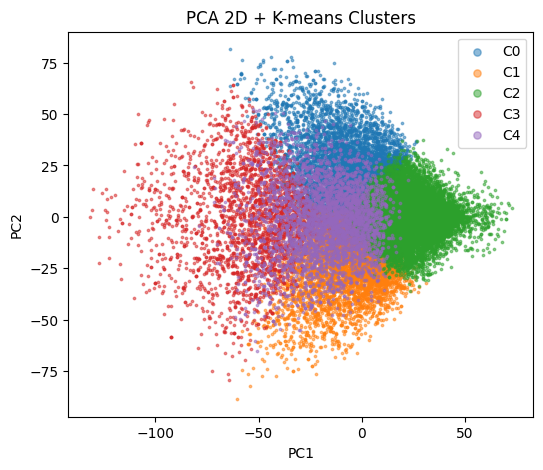

In [20]:
import matplotlib.pyplot as plt

K = 5  # 我分5群
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca50)

print("各群大小:", np.bincount(clusters))

plt.figure(figsize=(6,5))
for k in range(K):
    idx = (clusters == k)
    plt.scatter(X_pca2[idx, 0], X_pca2[idx, 1], s=3, alpha=0.5, label=f"C{k}")
plt.legend(markerscale=3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D + K-means Clusters")
plt.show()


Step 1 — flatten + PCA + K-means

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# 將 patch 攤平 (N, 64, 64, 1) → (N, 4096)
patches_flat = patches.reshape(patches.shape[0], -1)

# ---- PCA 降維 ---- #
pca = PCA(n_components=50, random_state=42)
patches_pca = pca.fit_transform(patches_flat)

# ---- K-means 分群 ---- #
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(patches_pca)

print("分群完成")
print("各群數量：", np.bincount(cluster_labels))


分群完成
各群數量： [10550 14744 14140  7154 33412]


Step 2 — 抽取每群 25 個 patch 作為代表

In [22]:
import random

samples_per_cluster = 25
cluster_samples = {}

for c in range(5):
    idx = np.where(cluster_labels == c)[0]
    chosen = np.random.choice(idx, samples_per_cluster, replace=False)
    cluster_samples[c] = patches[chosen]


Step 3 — 畫出 5×5 的代表圖（共五張圖，每張代表一群）

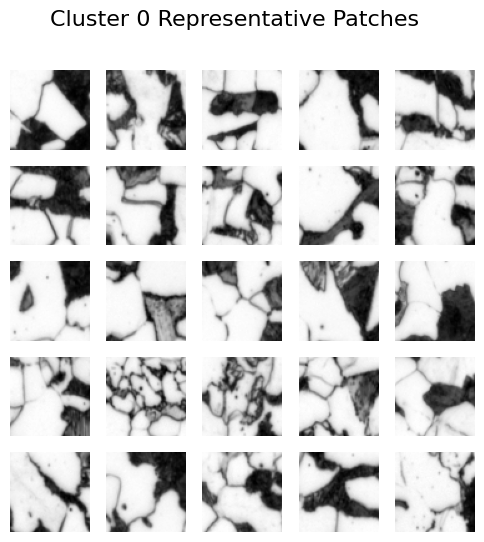

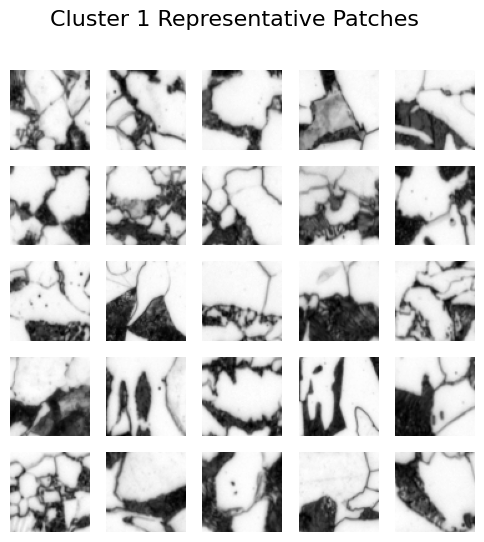

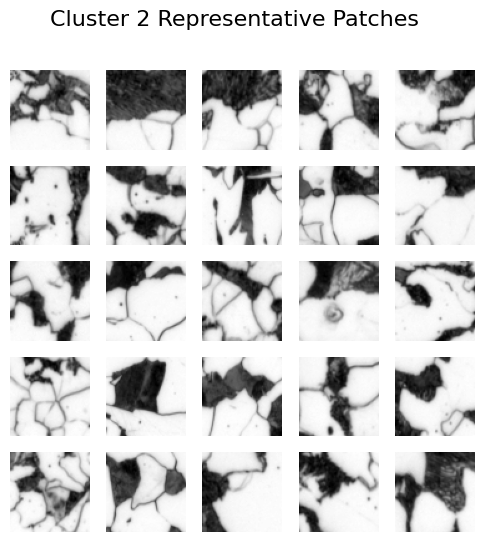

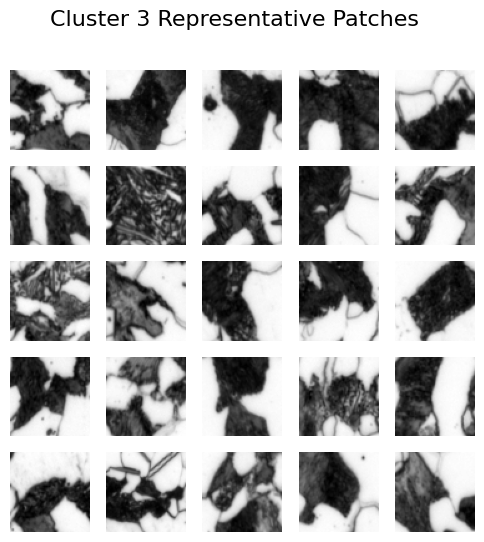

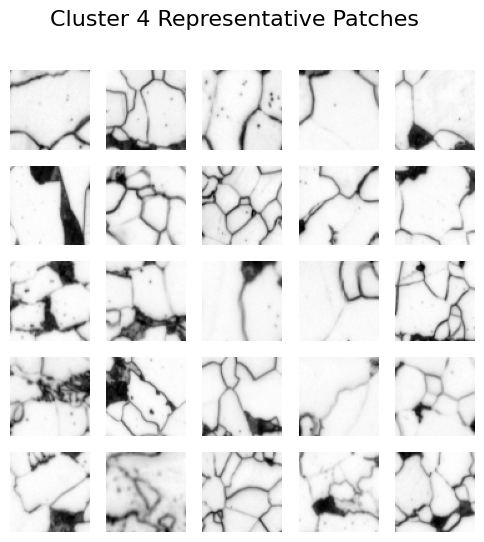

In [23]:
import matplotlib.pyplot as plt

for c in range(5):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    fig.suptitle(f"Cluster {c} Representative Patches", fontsize=16)

    for i in range(25):
        ax = axes[i//5, i%5]
        ax.imshow(cluster_samples[c][i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.show()


A4. 看每個 cluster 的代表 patch（材料角度解讀）

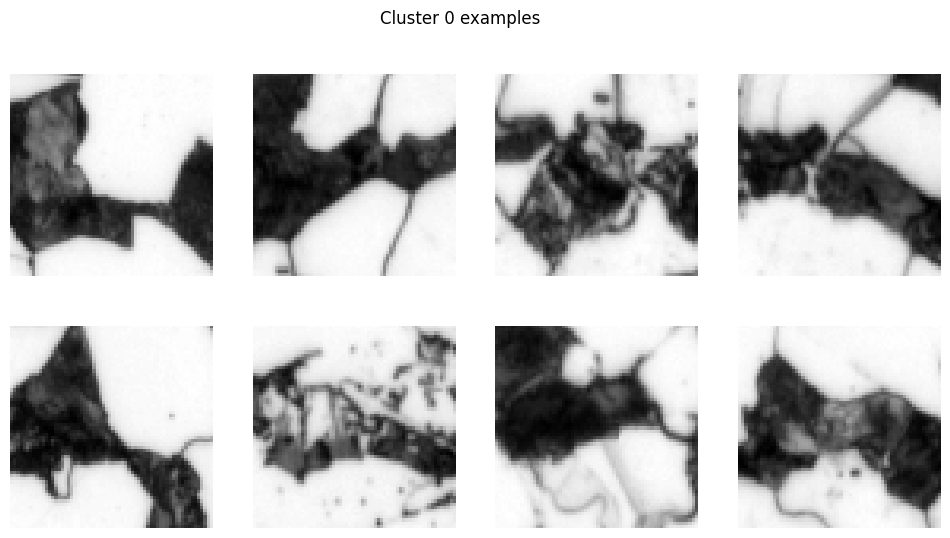

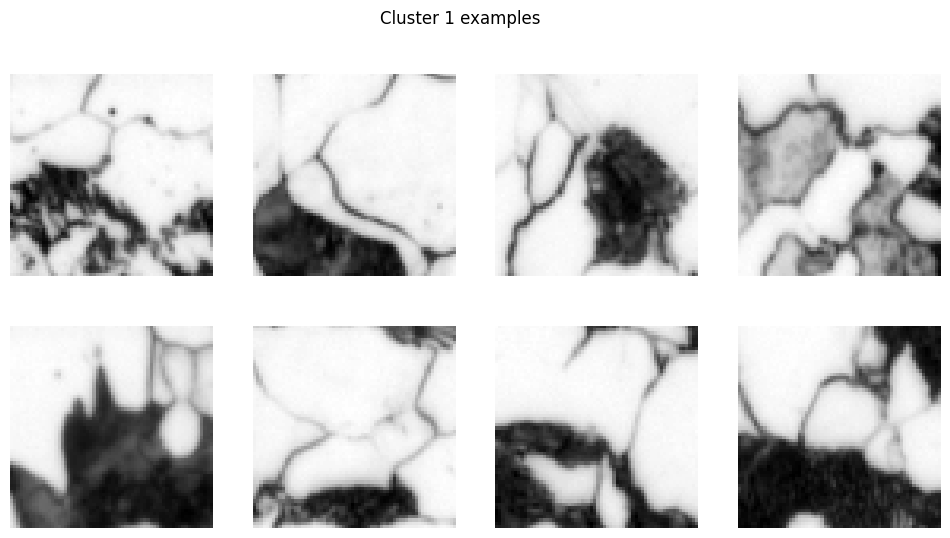

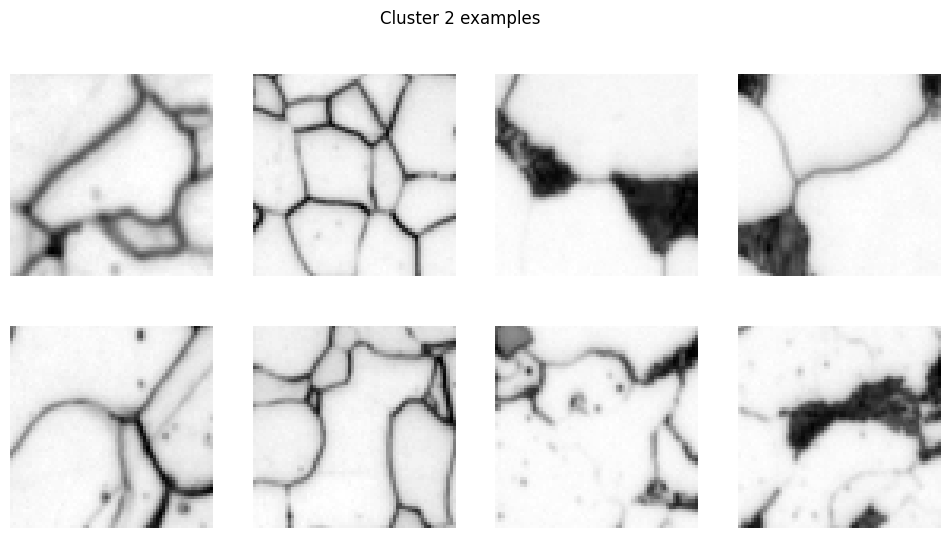

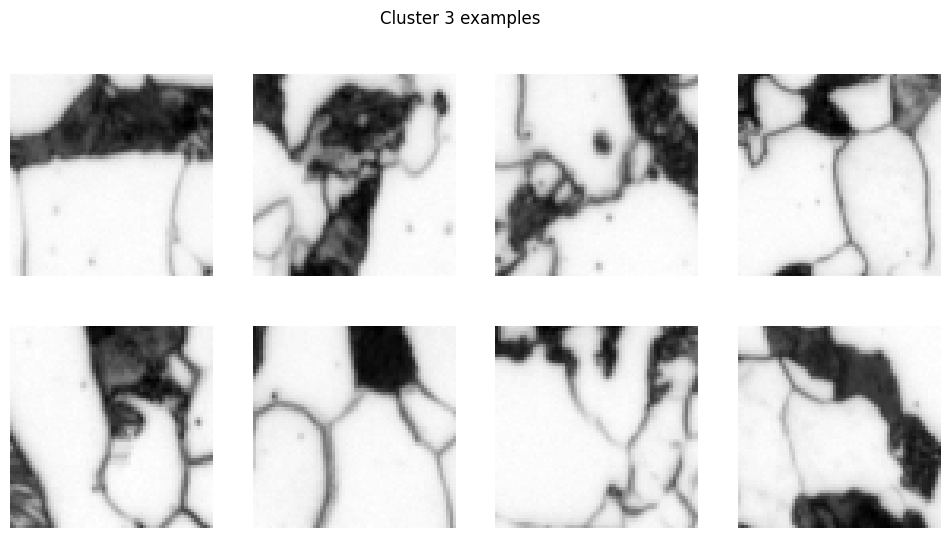

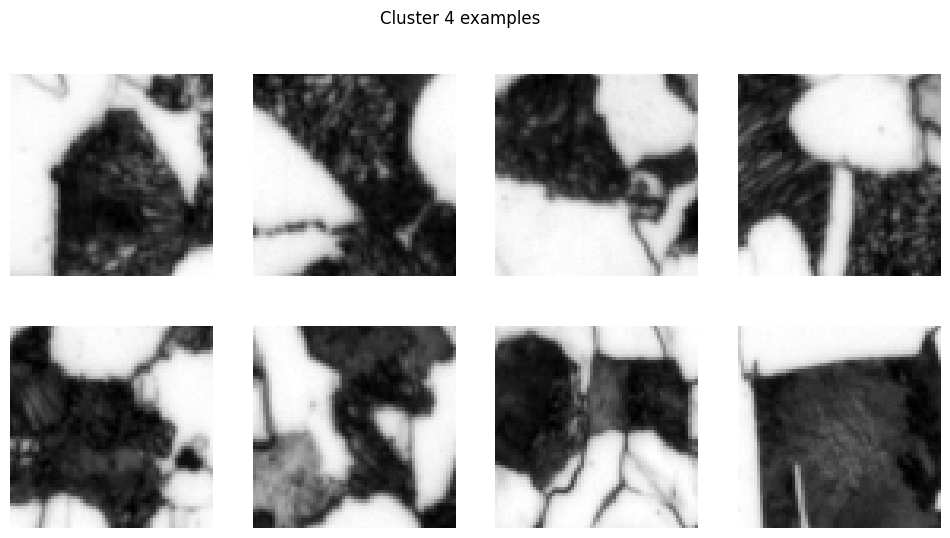

In [ ]:
def show_cluster_examples(cluster_id, num_examples=8):
    idx = np.where(clusters == cluster_id)[0]
    if len(idx) == 0:
        print(f"Cluster {cluster_id} 沒有樣本")
        return
    choose = np.random.choice(idx, size=min(num_examples, len(idx)), replace=False)
    imgs = X[choose, :, :, 0]

    cols = 4
    rows = int(np.ceil(len(imgs) / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id} examples")
    plt.show()

for k in range(K):
    show_cluster_examples(k)


A5. 把 cluster 畫回某張 SEM 圖（cluster map）

注意：我們切 patch 時是把每張圖 resize 成 (512, 512)，所以這裡也這樣做。

這張圖的 patch 數: 225


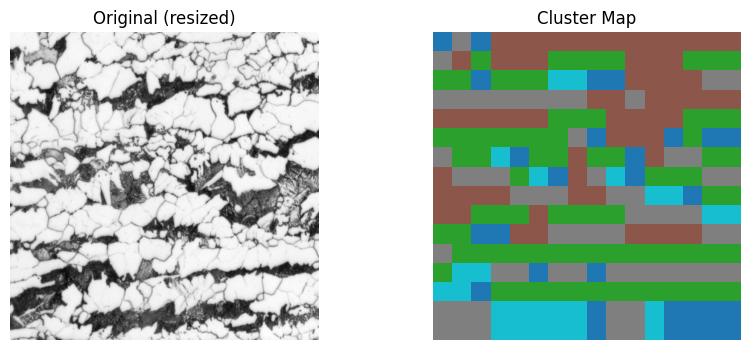

In [ ]:
import cv2
from pathlib import Path

DATA_ROOT = Path("/content/grainsize_dataset")
IMG_EXT = [".jpg", ".png", ".jpeg", ".tif", ".tiff"]
image_paths = [p for p in DATA_ROOT.rglob("*") if p.suffix.lower() in IMG_EXT]

# 只對前 N 個 patch 有 cluster 標籤
meta_used = meta[:N]

IMG_ID = 0  # 想看第幾張圖就改這裡

mask_img = (meta_used[:, 0] == IMG_ID)
coords_img = meta_used[mask_img][:, 1:3]   # (M, 2)
clusters_img = clusters[mask_img]          # (M,)

print("這張圖的 patch 數:", len(clusters_img))

# 讀並 resize 成 512x512
orig = cv2.imread(str(image_paths[IMG_ID]), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
orig = cv2.resize(orig, (512, 512), interpolation=cv2.INTER_AREA)
H, W = orig.shape

cluster_map = -1 * np.ones((H, W), dtype=int)
PATCH_SIZE = 64
STRIDE = 32

for (y, x), c in zip(coords_img, clusters_img):
    cluster_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = c

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original (resized)")
plt.imshow(orig, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Cluster Map")
plt.imshow(cluster_map, cmap='tab10', interpolation='nearest')
plt.axis('off')
plt.show()


Part B：Autoencoder + Reconstruction Error Heatmap
B1. 準備訓練資料（轉回 float32）

我們用全部 80k patch 訓練也 OK，如果你覺得太慢，可以只用 60k 左右。

In [ ]:
from sklearn.model_selection import train_test_split

X_all = patches.astype(np.float32)

MAX_TRAIN = 20000  #60000改20000(加快速度)
N_train_use = min(X_all.shape[0], MAX_TRAIN)
X_sub = X_all[:N_train_use]

X_train, X_val = train_test_split(X_sub, test_size=0.1, random_state=42)
print("Train:", X_train.shape, " Val:", X_val.shape)


Train: (18000, 64, 64, 1)  Val: (2000, 64, 64, 1)


B2. 建立 Autoencoder 模型並訓練

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (64, 64, 1)

inp = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inp)
x = layers.MaxPool2D((2,2))(x)              # 32x32
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)              # 16x16
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
encoded = layers.MaxPool2D((2,2))(x)        # 8x8x128

x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(encoded) # 16x16
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)        # 32x32
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)        # 64x64
decoded = layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)

autoencoder = models.Model(inp, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
]

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=15,#100改15
    batch_size=256,
    shuffle=True,
    callbacks=callbacks
)


Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step - loss: 0.0378 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 374s 5s/step - loss: 0.0160 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 389s 5s/step - loss: 0.0044 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 341s 5s/step - loss: 0.0029 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - loss: 0.0023 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 340s 5s/step - loss: 0.0020 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 345s 5s/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 10/15
71/71 ━

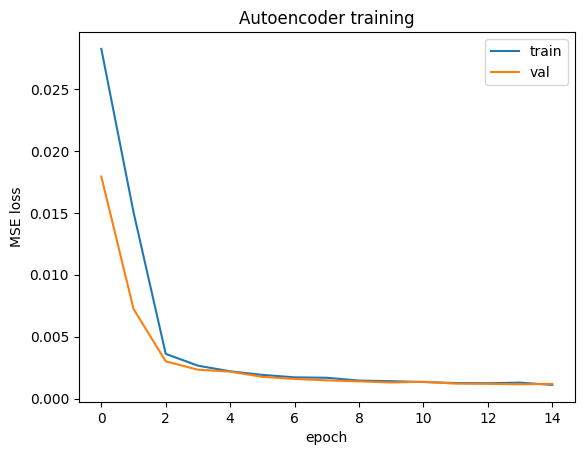

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.title('Autoencoder training')
plt.show()


B3. 對某張圖做 reconstruction error heatmap

In [ ]:
import cv2

def compute_recon_error_for_image(img_id, patches_all, meta_all, model,
                                  patch_size=64):
    # 找出屬於這張圖的 patch
    mask = (meta_all[:, 0] == img_id)
    coords = meta_all[mask][:, 1:3]
    patches_img = patches_all[mask]   # (M, 64, 64, 1)
    if patches_img.shape[0] == 0:
        raise ValueError(f"img_id {img_id} 沒有對應的 patch（因為前面截斷在 80k）")

    # AE 重建
    recon = model.predict(patches_img, batch_size=256, verbose=0)
    errors = np.mean((patches_img - recon)**2, axis=(1,2,3))  # (M,)

    # 讀原圖（resize 成 512x512，跟當初切 patch 一致）
    orig = cv2.imread(str(image_paths[img_id]), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    orig = cv2.resize(orig, (512, 512), interpolation=cv2.INTER_AREA)
    H, W = orig.shape

    error_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    for (y, x), e in zip(coords, errors):
        error_map[y:y+patch_size, x:x+patch_size] += e
        count_map[y:y+patch_size, x:x+patch_size] += 1.0

    count_map[count_map == 0] = 1.0
    error_map /= count_map

    return orig, error_map


B4. 畫 heatmap + 疊圖 + binary defect mask

In [25]:
IMG_ID = 50  # 想看哪一張換這裡

orig, error_map = compute_recon_error_for_image(
    img_id=IMG_ID,
    patches_all=patches.astype(np.float32),  # AE 推論用 float32
    meta_all=meta,
    model=autoencoder,
    patch_size=64
)

# 正規化到 0-1
em_norm = (error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-8)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Error Map")
plt.imshow(em_norm, cmap='inferno')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(orig, cmap='gray')
plt.imshow(em_norm, cmap='inferno', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'compute_recon_error_for_image' is not defined

如果想看「二值化缺陷區」：

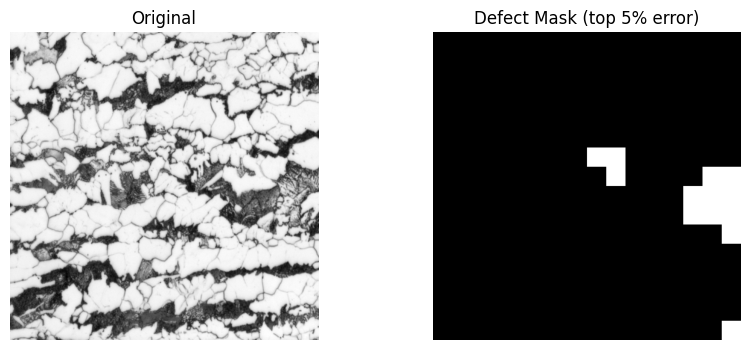

In [ ]:
threshold = np.quantile(error_map, 0.95)  # 取 error 前 5% 當 anomaly
defect_mask = (error_map >= threshold)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(orig, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Defect Mask (top 5% error)")
plt.imshow(defect_mask, cmap='gray')
plt.axis('off')
plt.show()
